In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dprasannavenkatesh","key":"09a552d9b412718c3ecdece5322d84b4"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!pip install -q kaggle


In [4]:
!kaggle datasets download dprasannavenkatesh/brain-tumor-dataset

Dataset URL: https://www.kaggle.com/datasets/dprasannavenkatesh/brain-tumor-dataset
License(s): unknown
100% 510M/512M [00:03<00:00, 71.6MB/s]
100% 512M/512M [00:03<00:00, 166MB/s] 


In [5]:
!unzip -q brain-tumor-dataset.zip

In [6]:
pip install split-folders

In [ ]:
import os
import shutil
import splitfolders 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np


input_folder = "/content/Brain/Data"   
output_folder = "dataset_split"

os.makedirs("dataset_ready", exist_ok=True)


shutil.copytree(os.path.join(input_folder, "Normal"), "dataset_ready/normal", dirs_exist_ok=True)


for sub in ["glioma_tumor", "meningioma_tumor", "pituitary_tumor"]:
    shutil.copytree(os.path.join(input_folder, "Tumor", sub), f"dataset_ready/{sub}", dirs_exist_ok=True)


splitfolders.ratio("dataset_ready", output=output_folder, seed=42, ratio=(0.8, 0.2))


train_normal_dir = os.path.join(output_folder, "train", "normal")
augmented_dir = os.path.join(output_folder, "train", "normal")  


glioma_count = len(os.listdir(os.path.join(output_folder, "train", "glioma_tumor")))
meningioma_count = len(os.listdir(os.path.join(output_folder, "train", "meningioma_tumor")))
pituitary_count = len(os.listdir(os.path.join(output_folder, "train", "pituitary_tumor")))

target_count = max(glioma_count, meningioma_count, pituitary_count)  
normal_count = len(os.listdir(train_normal_dir))

print(f"Normal count: {normal_count}, Target: {target_count}")


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

i = 0
normal_images = os.listdir(train_normal_dir)

for img_name in normal_images:
    img_path = os.path.join(train_normal_dir, img_name)
    img = load_img(img_path)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=augmented_dir,
                              save_prefix="aug",
                              save_format="jpg"):
        i += 1
        if i >= (target_count - normal_count):  
            break
    if i >= (target_count - normal_count):
        break

print(" Data augmentation complete. Normal class balanced.")


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation


from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


print(f'Tensorflow Version: {tf.__version__}')
print("GPU Available:", tf.config.list_physical_devices('GPU')[0])

SEED = 111


%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

Tensorflow Version: 2.19.0
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [9]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:

USER_PATH = "/content/dataset_split"
train_paths, train_index = get_data_labels(USER_PATH + '/train', random_state=SEED)
test_paths, test_index = get_data_labels(USER_PATH + '/val', random_state=SEED)


print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')


batch_size = 32
image_dim = (224, 224)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


print(f"\nTraining dataset: {train_ds}")
print(f"\nTesting dataset: {test_ds}")


class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

Training
Number of Paths: 25292
Number of Labels: 25292

Testing
Number of Paths: 6141
Number of Labels: 6141

Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


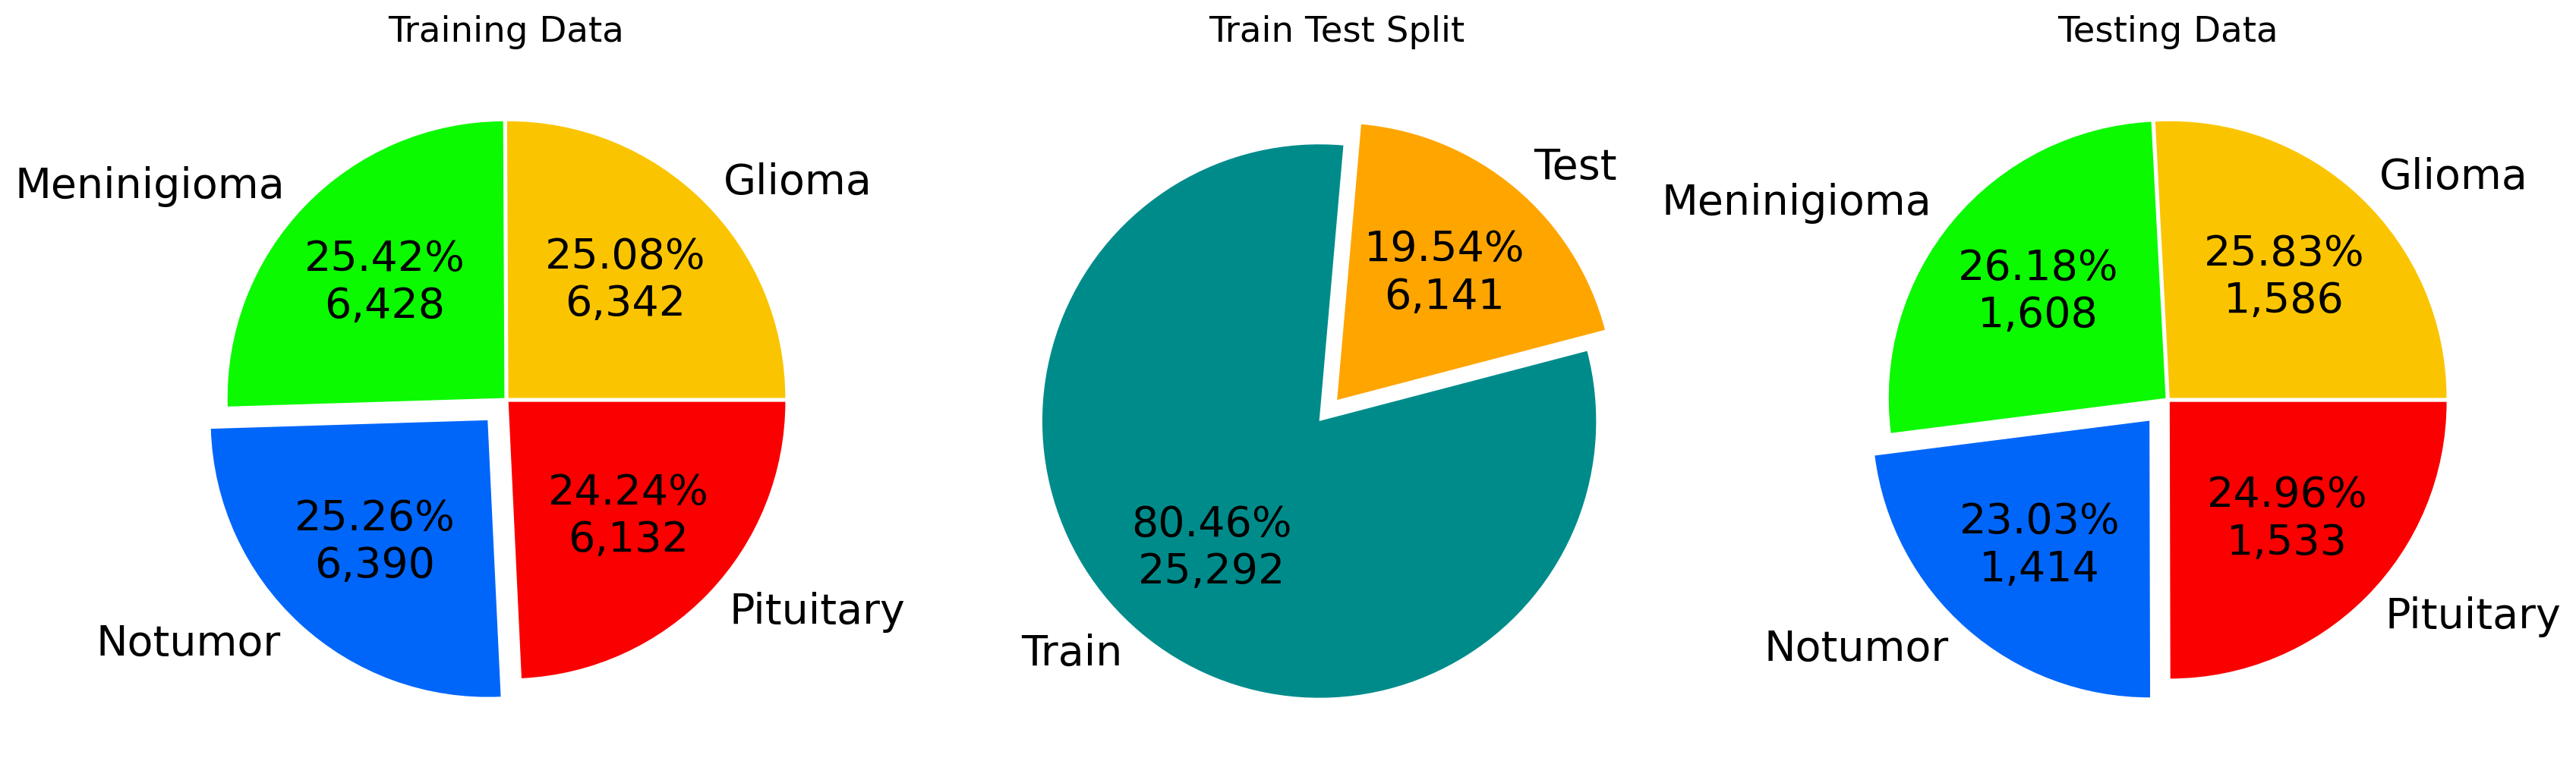

In [ ]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))


class_counts = [len([x for x in train_index if x == label]) for label in set(train_index)]
ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)


ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_index), len(test_index)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_index), len(test_index)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)


class_counts = [len([x for x in test_index if x == label]) for label in set(test_index)]
ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)

plt.show()

In [ ]:

def show_images(paths, label_paths, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    index_to_class = {v: k for k, v in class_mappings.items()}
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        image = load_img(paths[index], target_size=(im_size, im_size), color_mode='grayscale')
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_paths[index]]
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

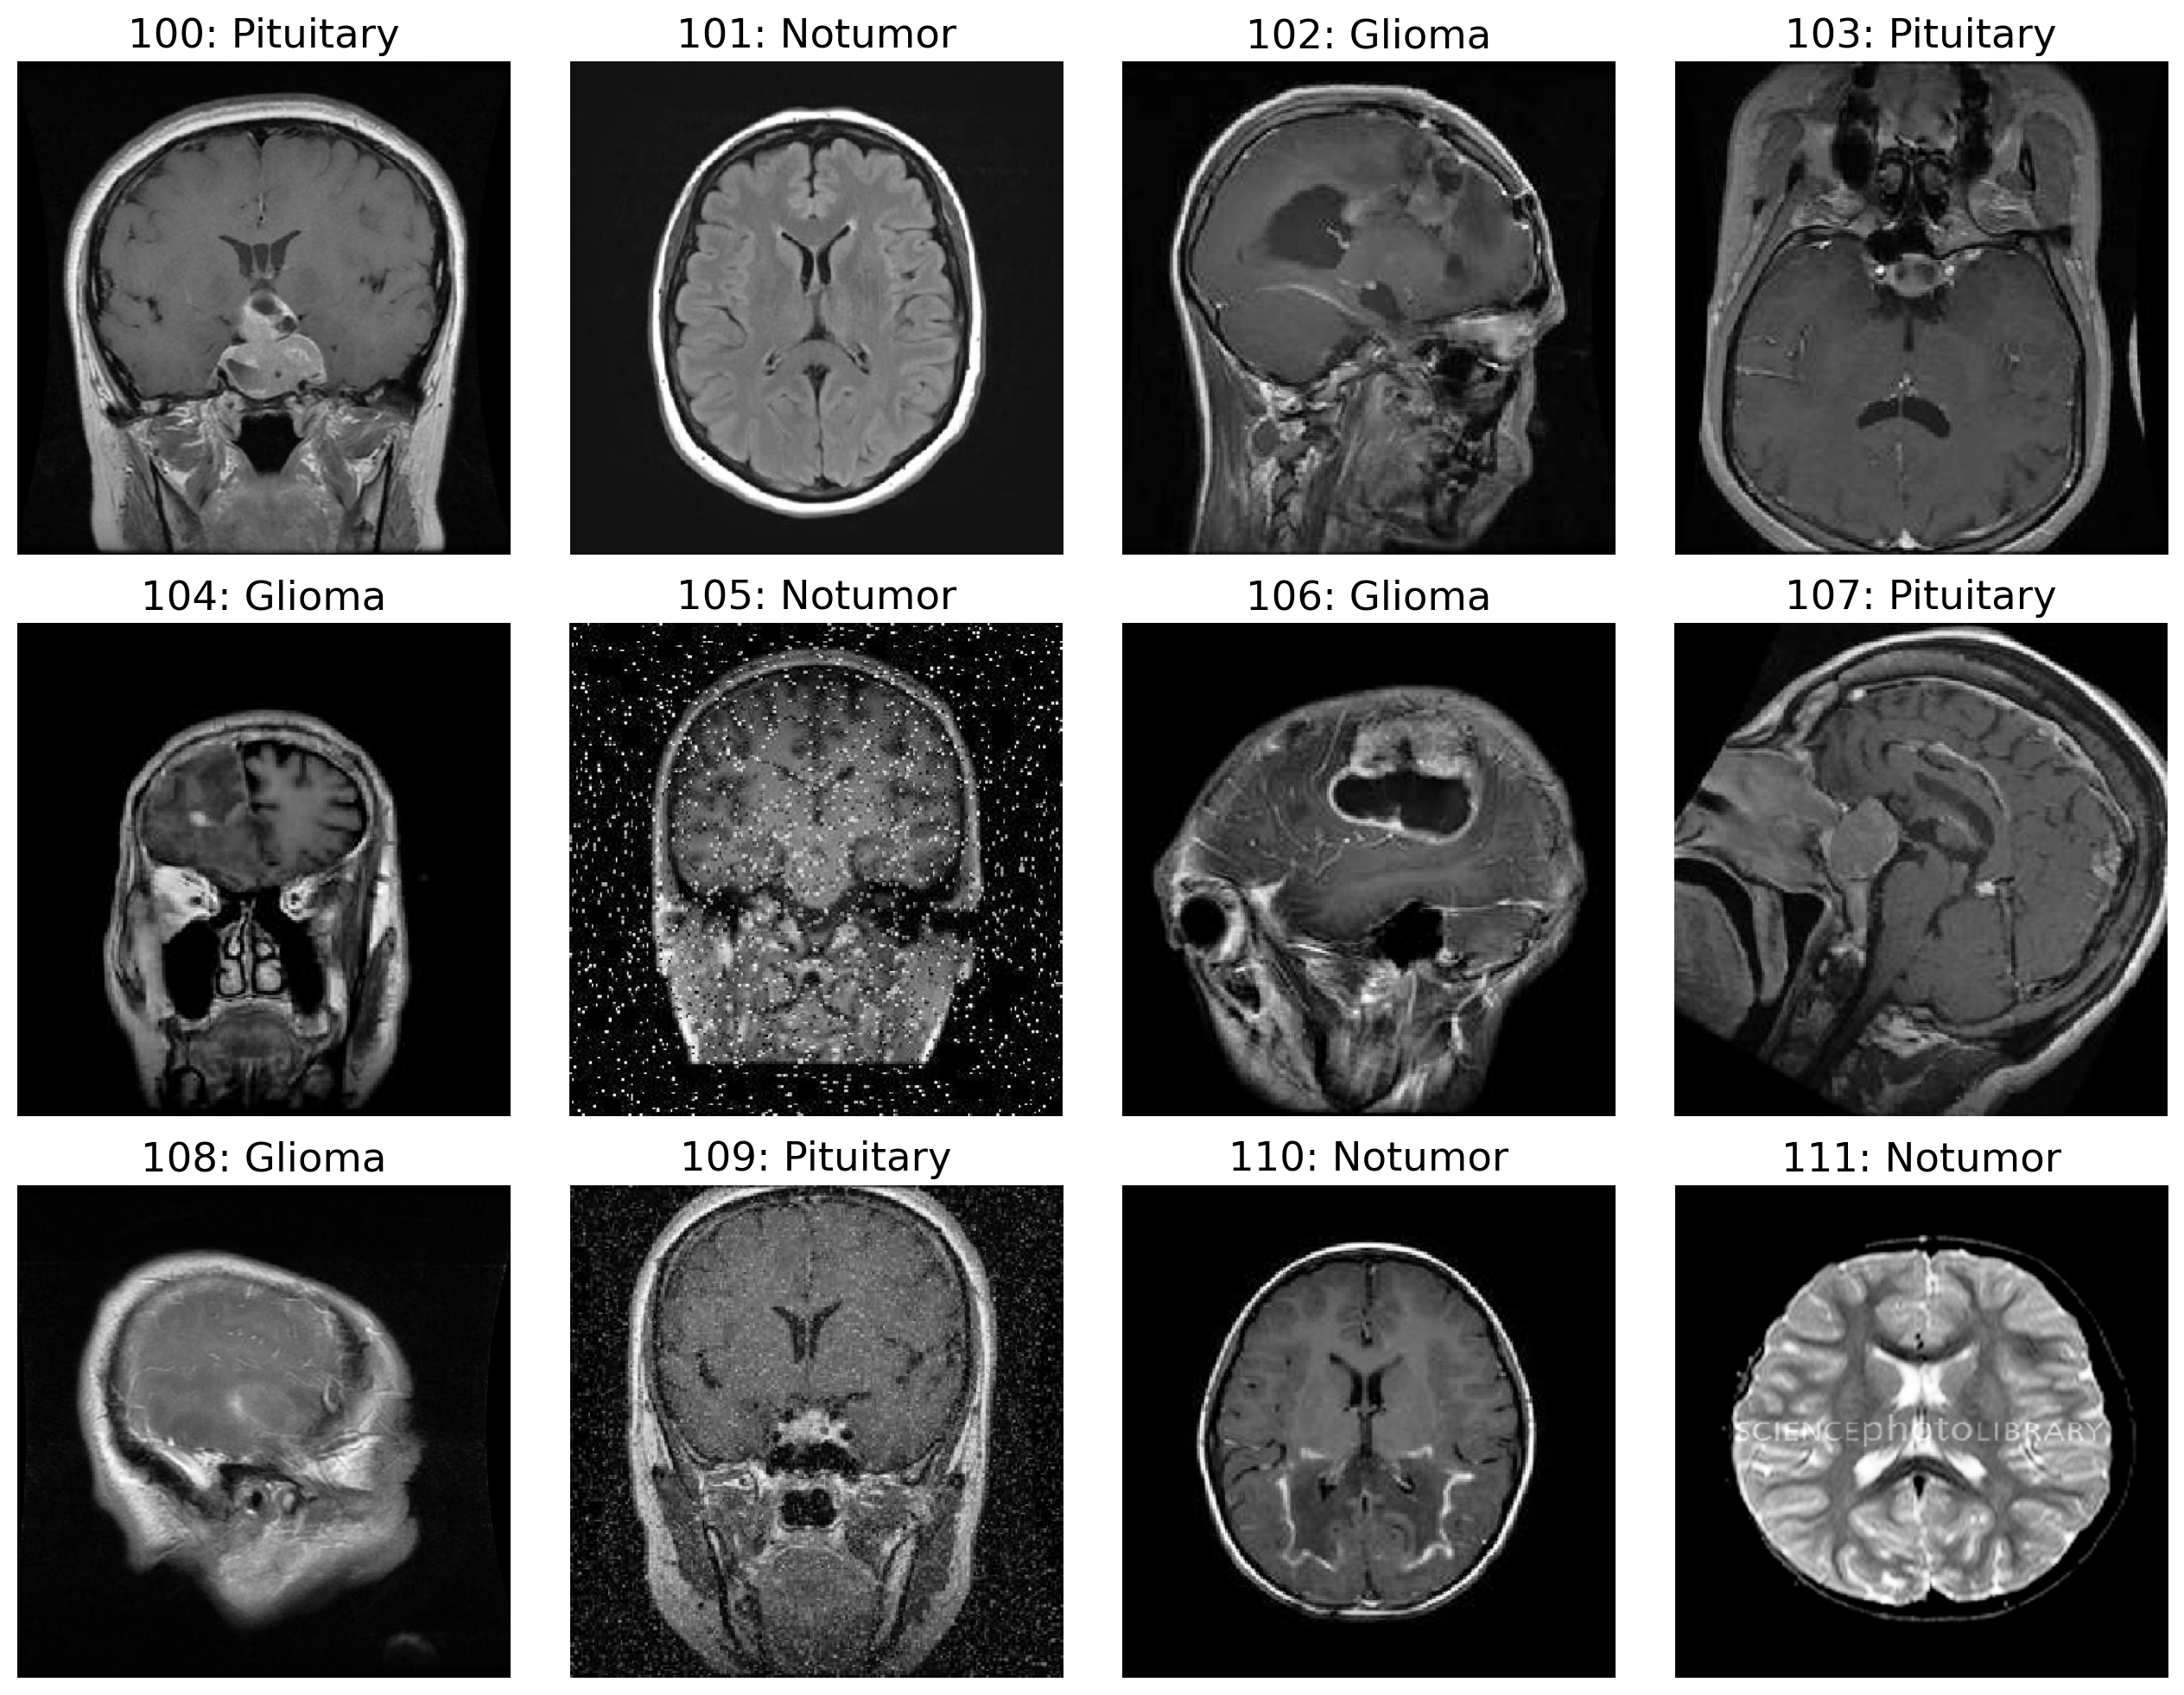

In [ ]:

show_images(train_paths, train_index, class_mappings, im_size=350, figsize=(13,10),
            index_list=range(100, 112))

In [ ]:

data_augmentation = Sequential([
   
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])


def preprocess_train(image, label):
   
    image = data_augmentation(image) / 255.0
    return image, label


def preprocess_test(image, label):
    return image / 255.0, label


train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:

def plot_augmented_images(dataset, shape, class_mappings, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    index_to_class = {v: k for k, v in class_mappings.items()}
    for images, label in dataset.take(1):
        i = 0
        for i in range(shape[0]*shape[1]):
            ax = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(index_to_class[label.numpy()[i]])
            plt.axis("off")
            i += 1

    plt.tight_layout()
    plt.show()

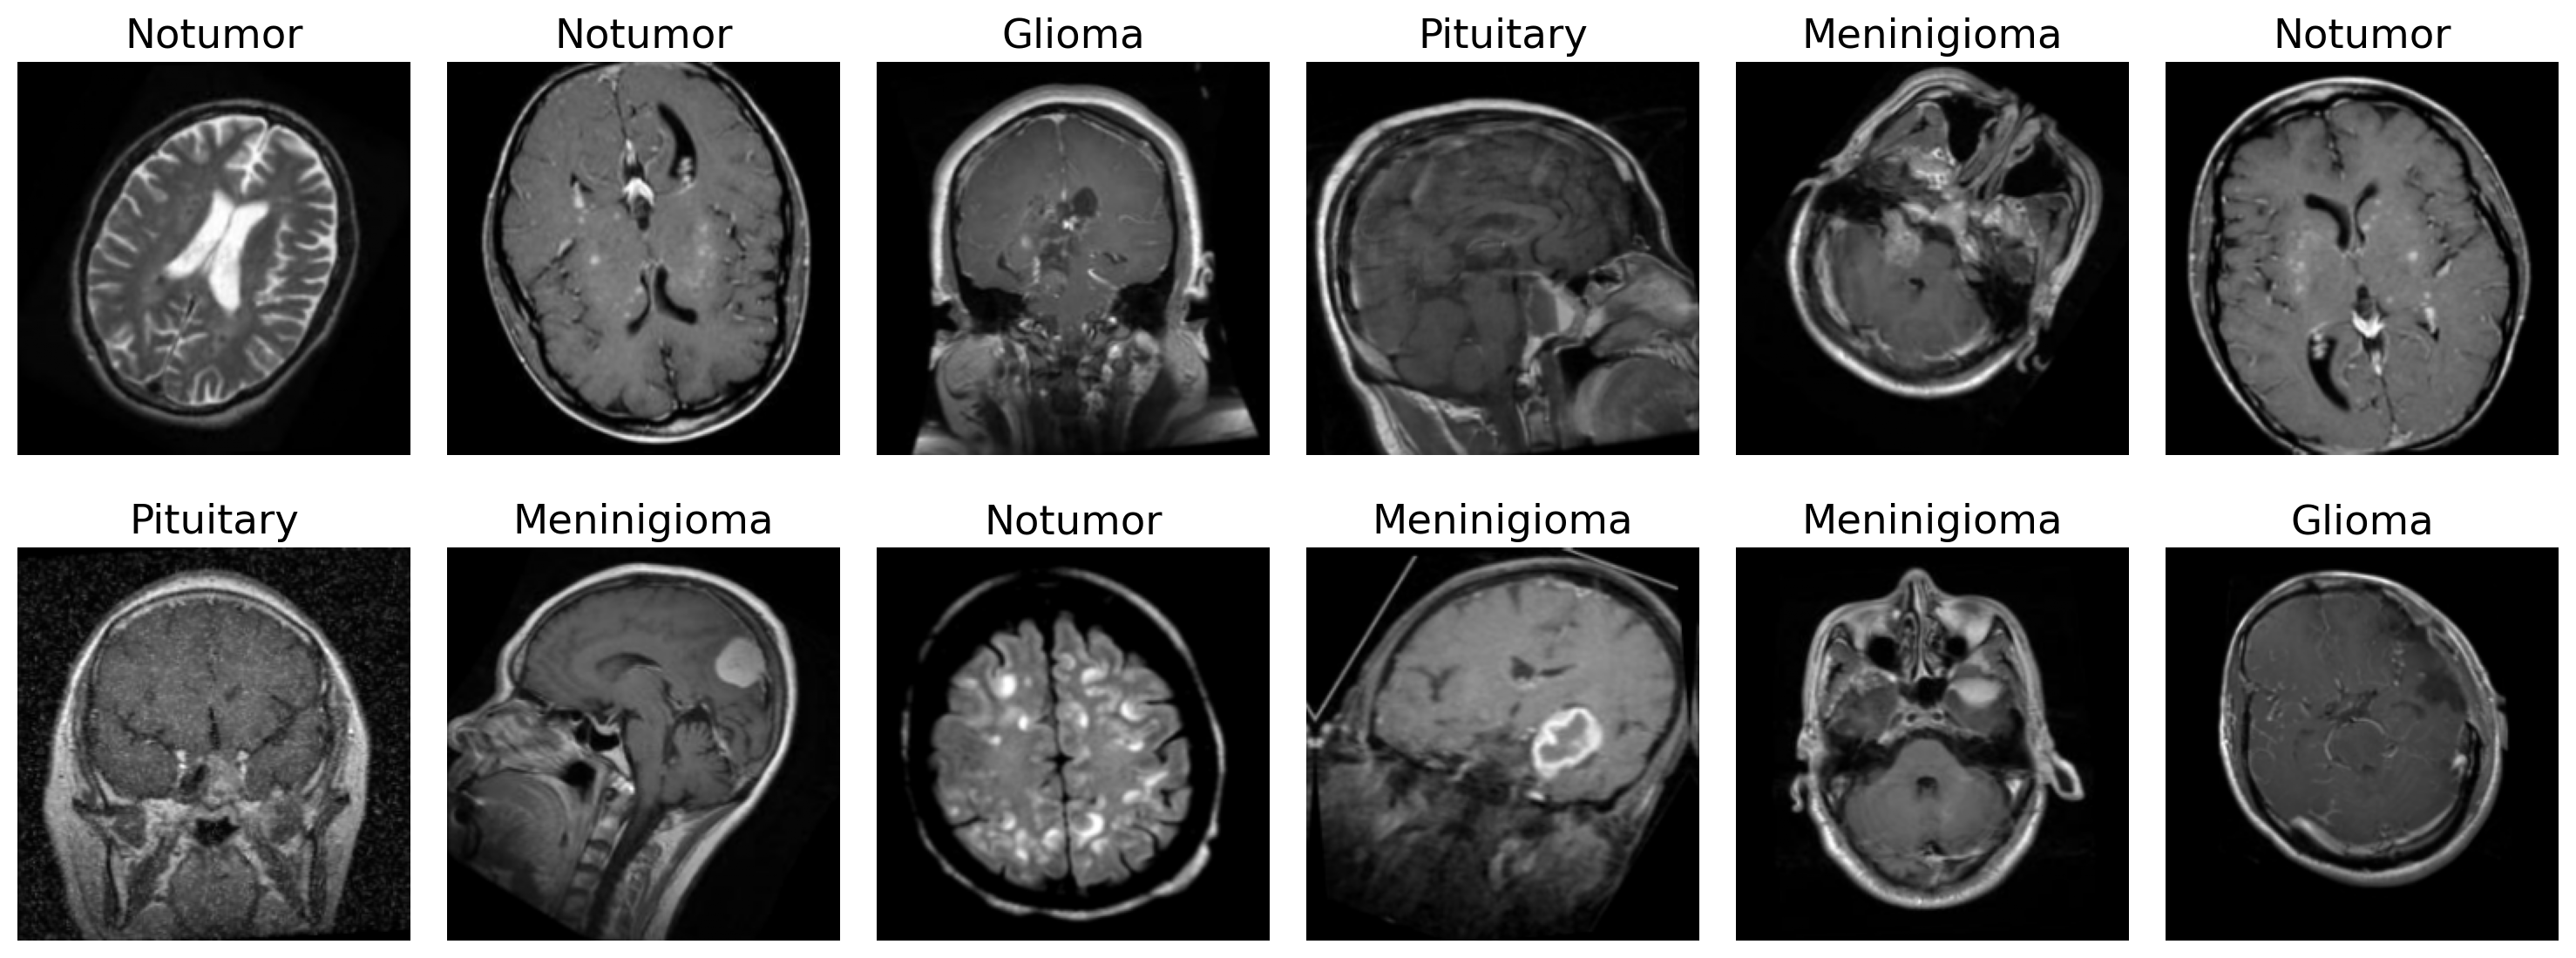

In [ ]:

plot_augmented_images(train_ds_preprocessed, shape=(2, 6), class_mappings=class_mappings)

In [ ]:

num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

Number of Classes: 4
Image shape: (224, 224, 1)
Epochs: 50
Batch size: 32


In [ ]:

model = Sequential([

    Input(shape=image_shape),


    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),


    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),


    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),


    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

 
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])


model.summary()


optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,089,988 (4.16 MB)

 Trainable params: 1,089,988 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  
        self.factor = factor  
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds) 

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True 
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")


thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [ ]:

model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)


history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 142s 168ms/step - accuracy: 0.5986 - loss: 0.9093 - val_accuracy: 0.8987 - val_loss: 0.3009 - learning_rate: 0.0010
Epoch 2/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 122s 153ms/step - accuracy: 0.9050 - loss: 0.2650 - val_accuracy: 0.9277 - val_loss: 0.2050 - learning_rate: 0.0010
Epoch 3/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 119s 150ms/step - accuracy: 0.9433 - loss: 0.1606 - val_accuracy: 0.9606 - val_loss: 0.1261 - learning_rate: 0.0010
Epoch 4/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 120s 152ms/step - accuracy: 0.9583 - loss: 0.1243 - val_accuracy: 0.9404 - val_loss: 0.1664 - learning_rate: 0.0010
Epoch 5/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 120s 151ms/step - accuracy: 0.9688 - loss: 0.0914 - val_accuracy: 0.9658 - val_loss: 0.1096 - learning_rate: 0.0010
Epoch 6/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 143s 152ms/step - accuracy: 0.9736 - loss: 0.0788 - val_accuracy: 0.9702 - val_loss: 0.0975 - learning_rate: 0.0010
Epoch 7/50
791/791 ━━━━━━━━━━━━━━━━━━━━ 119s 151ms/step - accura

In [ ]:

model = load_model('model.keras')


test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9925 - loss: 0.0565
Test accuracy: 99.1207%


In [ ]:
model.save('Brain.keras')
print("Model saved as Brain.keras")

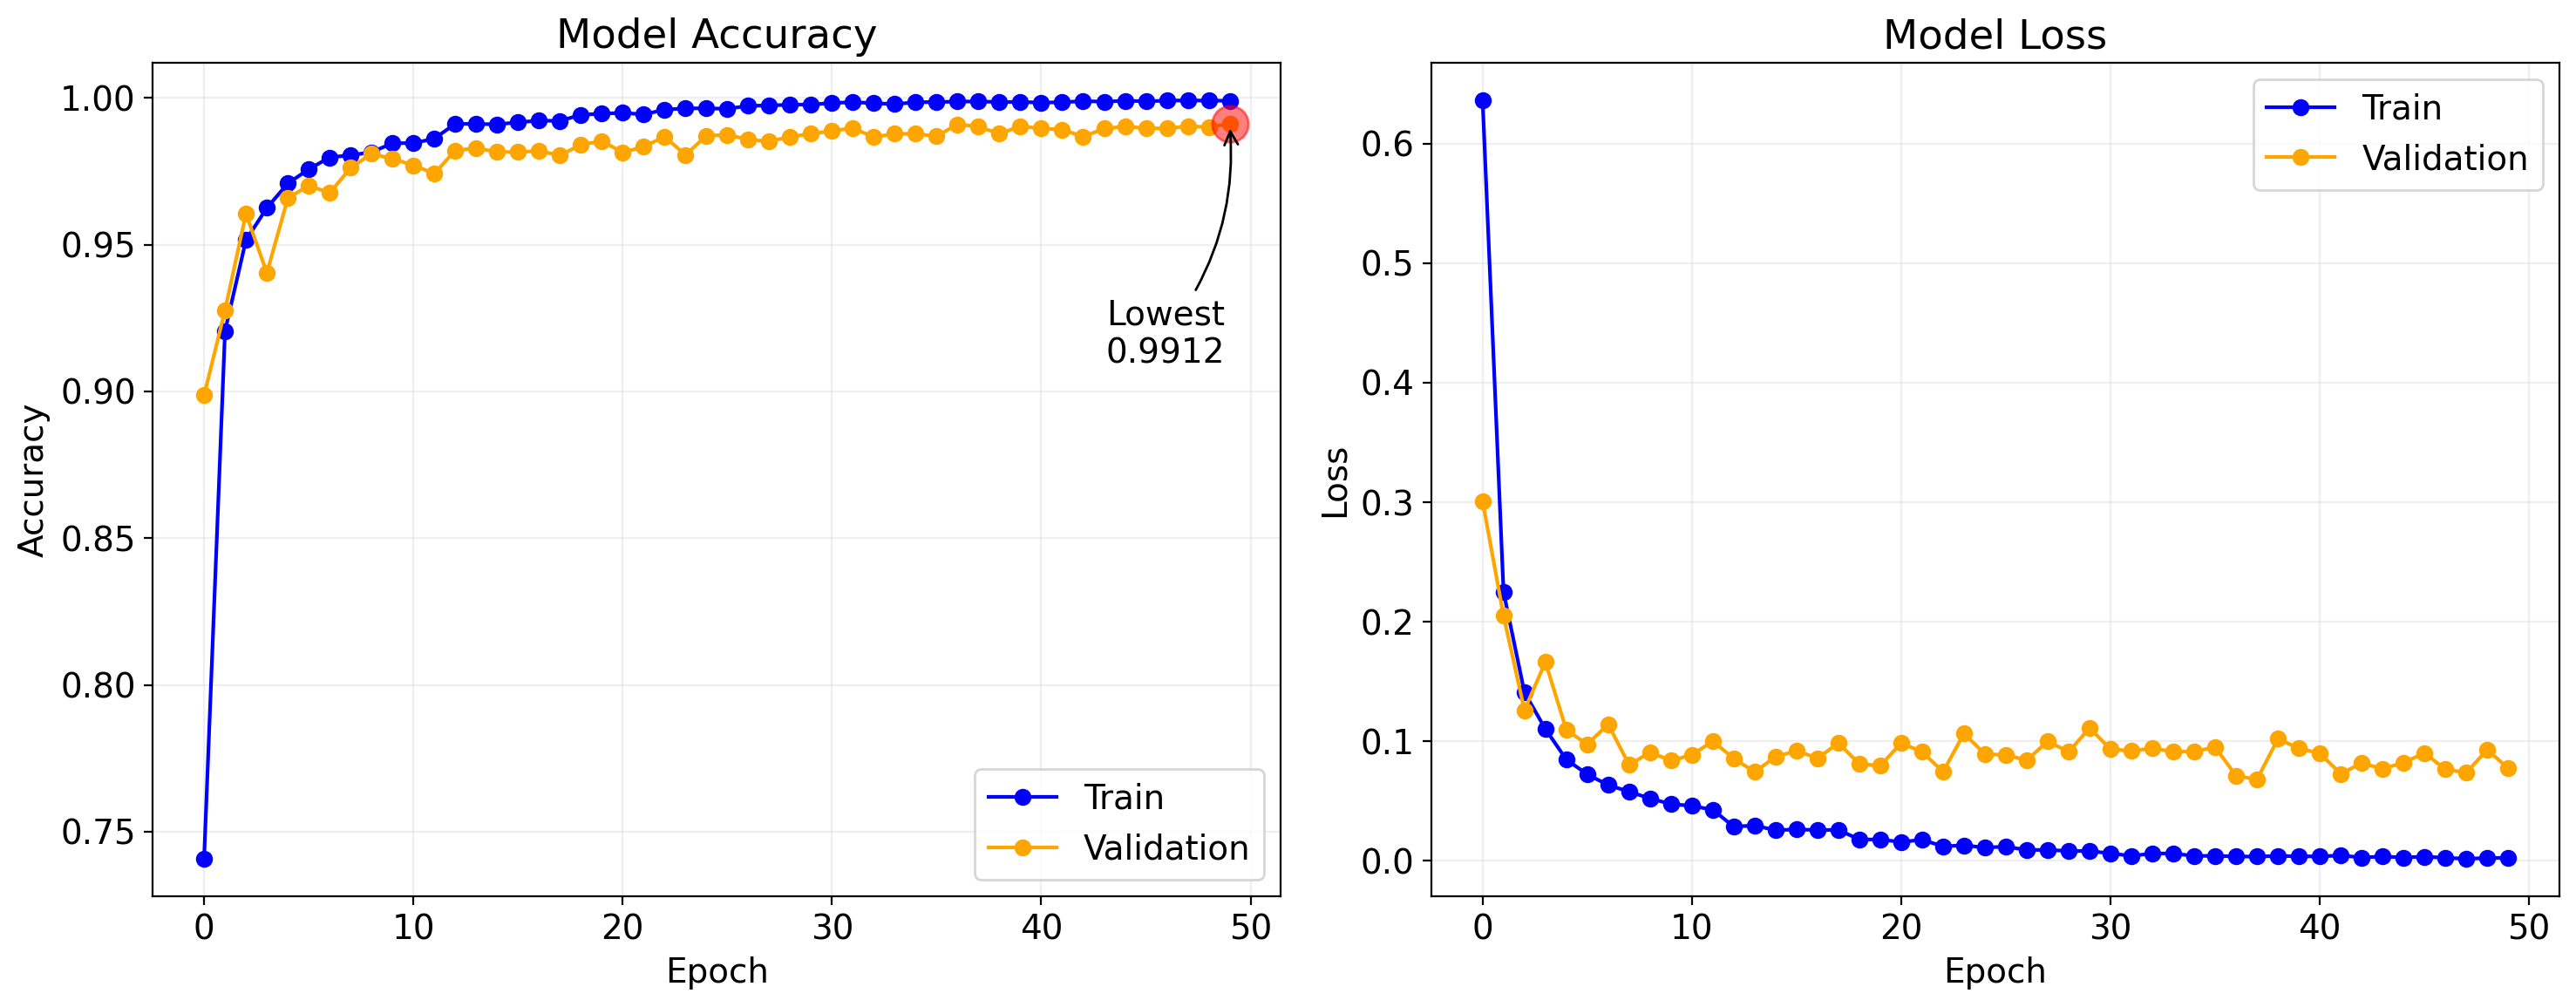

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))


ax[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
ax[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='lower right')
ax[0].grid(alpha=0.2)


ax[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
ax[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')
ax[1].grid(alpha=0.2)


min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
ax[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
ax[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [ ]:

true_labels = []
predicted_labels = []


for images, labels in test_ds_preprocessed.unbatch():

    true_label = np.argmax(labels.numpy())
    true_labels.append(true_label)


    pred = model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels, class_mappings, metrics=False, cmap='Blues'):

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

  
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), va='center')
    plt.show()

    if metrics:
     
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_mappings)):
            class_name = list(class_mappings.keys())[i]
            print(f"\033[94mClass: {class_name}\033[0m")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"\033[92mOverall Accuracy: {accuracy:.4f}\033[0m")

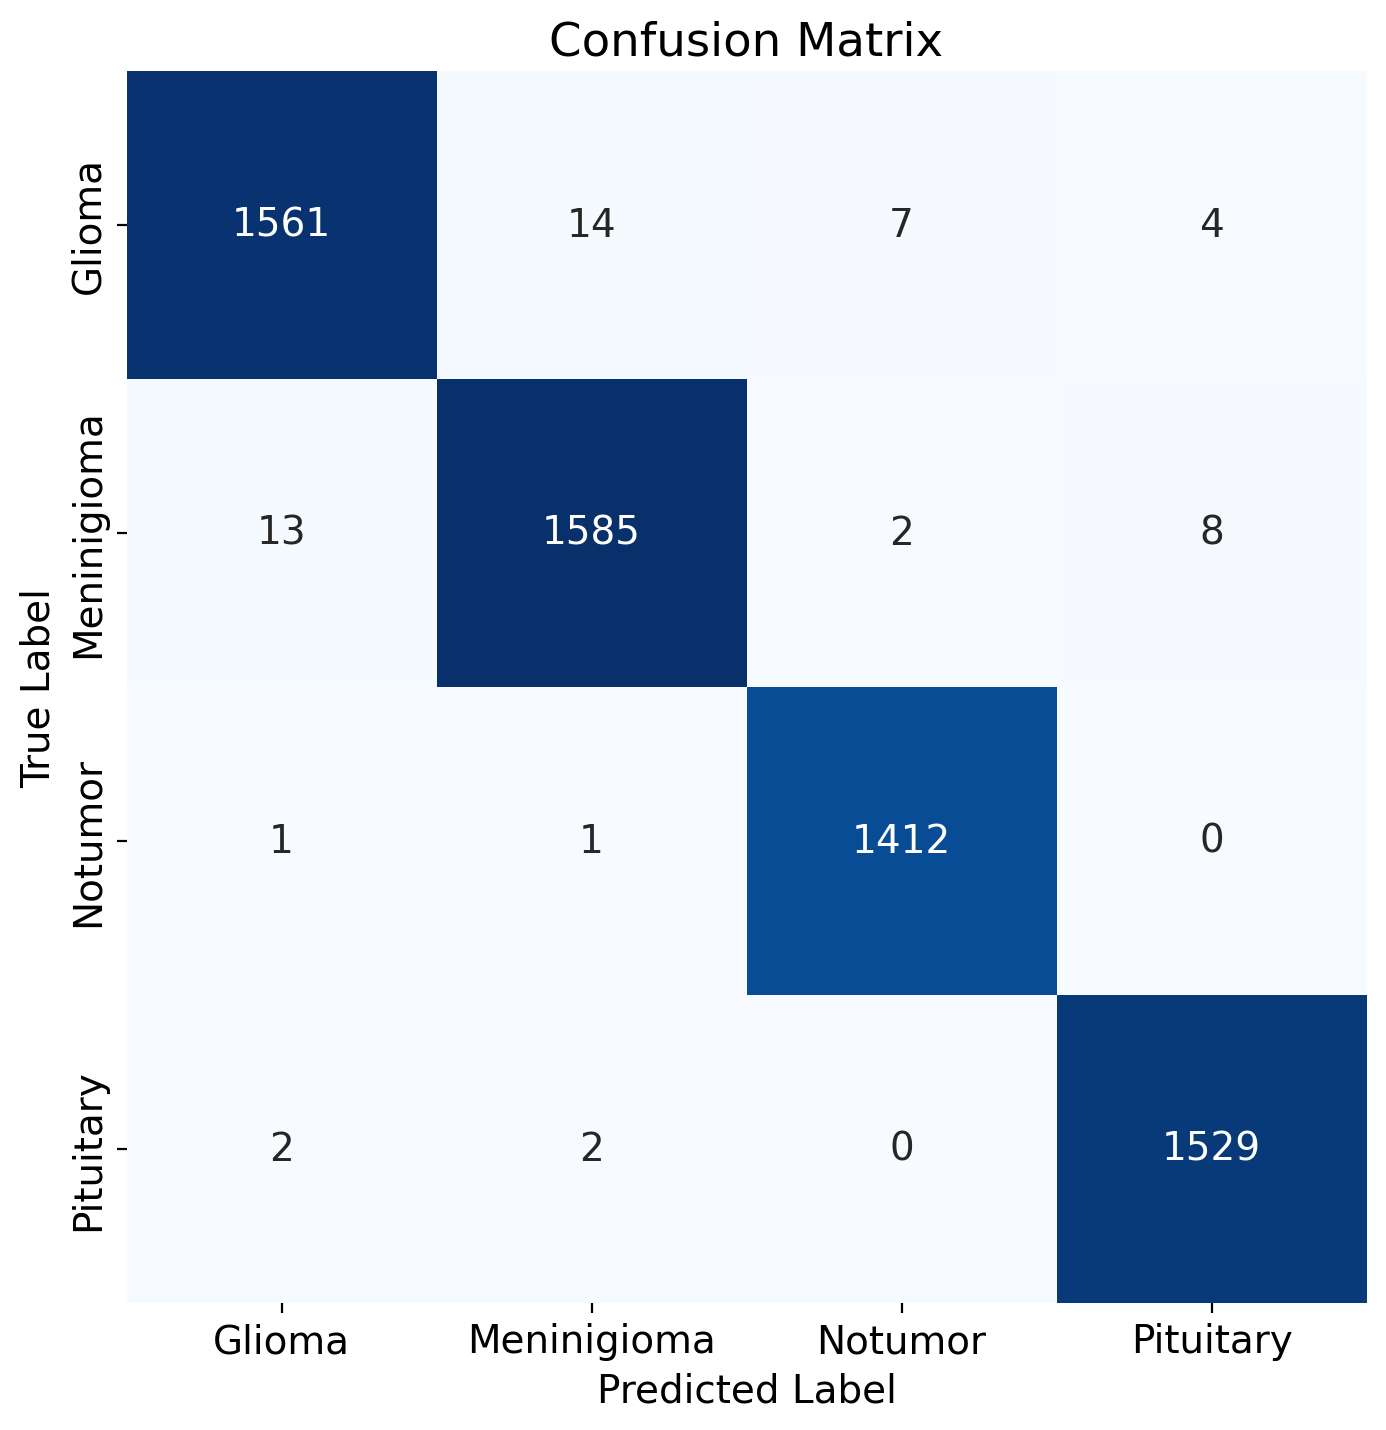

Class-wise metrics:
Class: Glioma
Precision: 0.9899
Recall: 0.9842
F1-Score: 0.9870

Class: Meninigioma
Precision: 0.9894
Recall: 0.9857
F1-Score: 0.9875

Class: Notumor
Precision: 0.9937
Recall: 0.9986
F1-Score: 0.9961

Class: Pituitary
Precision: 0.9922
Recall: 0.9974
F1-Score: 0.9948

Overall Accuracy: 0.9912


In [ ]:

plot_confusion_matrix(true_labels,
                      predicted_labels,
                      class_mappings,
                      metrics=True)

In [ ]:
def plot_sample_predictions(model, dataset, index_to_class, num_samples=9, figsize=(13, 12)):
    plt.figure(figsize=figsize)
    num_rows = num_cols = int(np.sqrt(num_samples))

    iterator = iter(dataset.unbatch())

    for i in range(1, num_samples + 1):
        image, true_label = next(iterator)
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]

        true_class_index = np.argmax(true_label.numpy())
        true_class = index_to_class[true_class_index]
        predicted_class = index_to_class[predicted_label]

      
        title_color = 'green' if true_class_index == predicted_label else 'red'

        plt.subplot(num_rows, num_cols, i)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

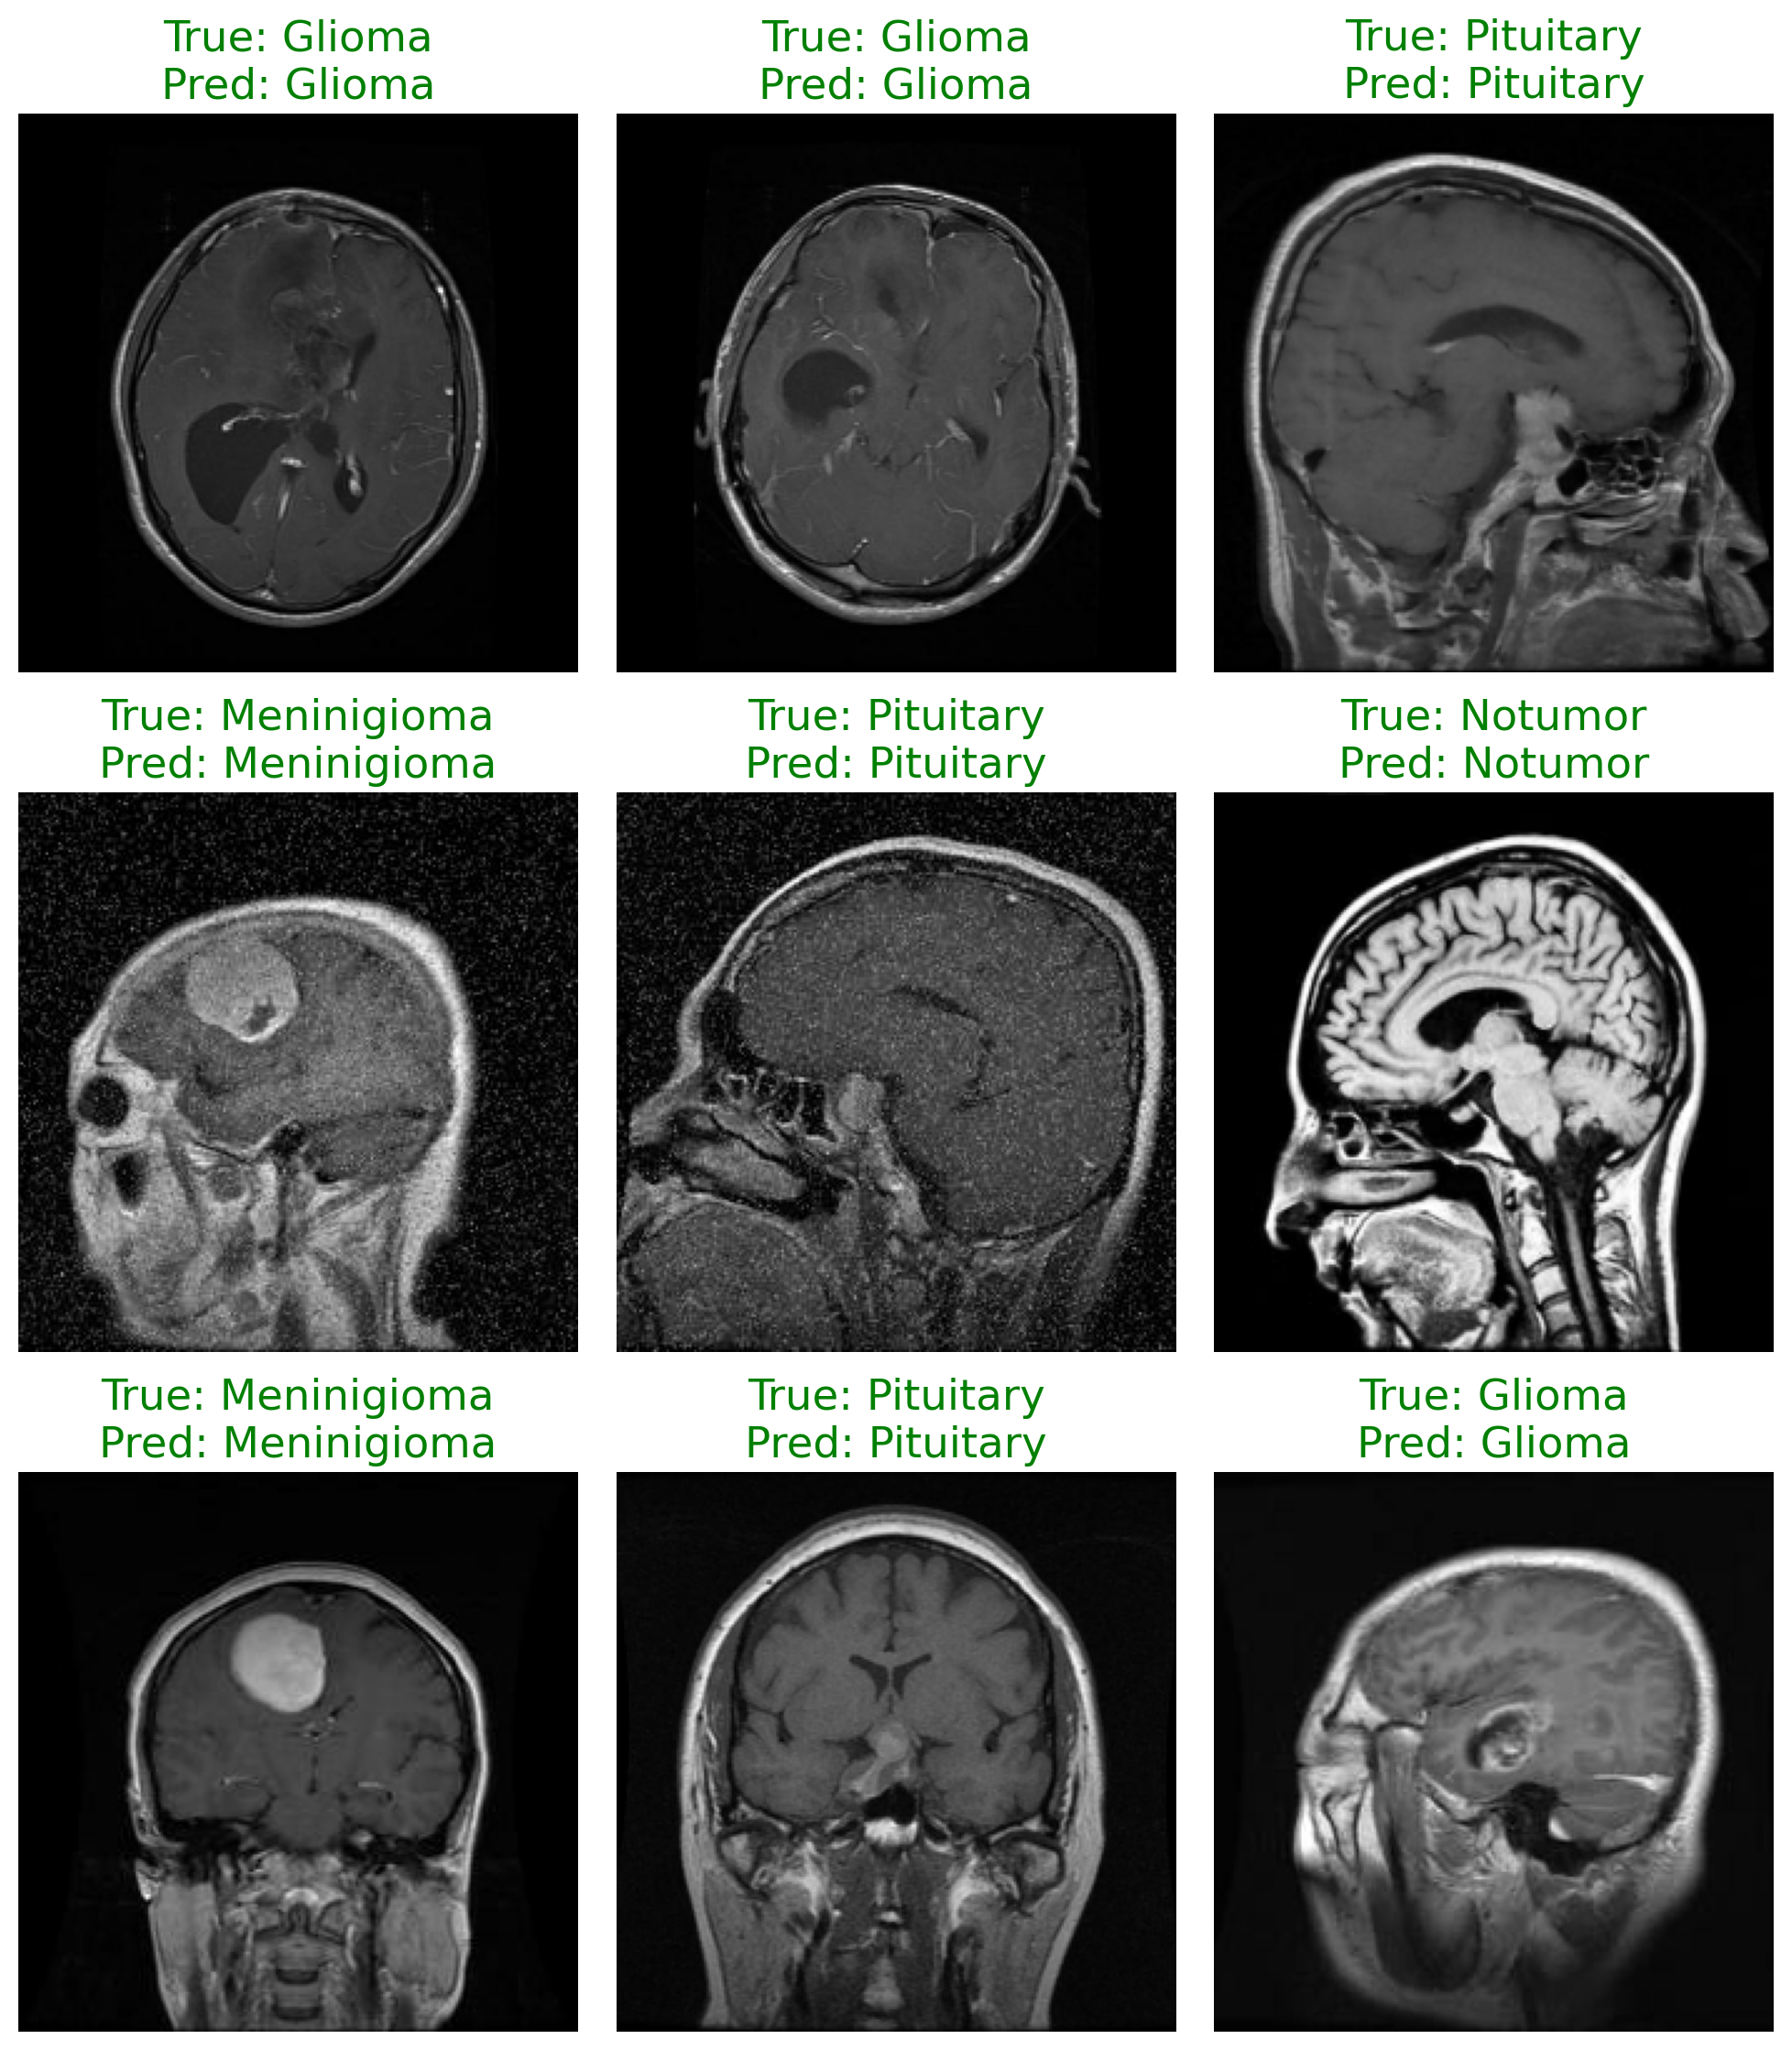

In [ ]:

plot_sample_predictions(model=model,
                        dataset=test_ds_preprocessed,
                        index_to_class=inv_class_mappings,
                        num_samples=9,
                        figsize=(10, 11.5))

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import load_model 


model = load_model('model.keras')


class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Normal': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}


def preprocess_single_image(image_path, image_size, n_channels):
    img = load_img(image_path, target_size=image_size, color_mode='grayscale' if n_channels == 1 else 'rgb')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0 
    return img_array


uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

   
    image_dim = (224, 224)

   
    img_to_predict = preprocess_single_image(filename, image_dim, 1) 


    predictions = model.predict(img_to_predict)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = inv_class_mappings[predicted_class_index]

    print(f"The predicted class for {filename} is: {predicted_class}")

Saving Tr-me_0020.jpg to Tr-me_0020 (3).jpg
Uploaded file: Tr-me_0020 (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
The predicted class for Tr-me_0020 (3).jpg is: Meninigioma
